# WiDS Datathon 2026 Notebook
This is where your analysis begins. Use this notebook for EDA, modeling, and explanations.

# WiDS Datathon 2026 – Route 1: Accelerating Equitable Evacuations

**Goal:** Identify evacuation alert delays and build an early-trigger recommendation baseline using WatchDuty data.

**Core KPI:** Minutes of lead time gained (how much earlier we could trigger protective action).



In [4]:
import pandas as pd
import numpy as np
import json

pd.set_option("display.max_columns", 200)




In [10]:
events = pd.read_csv("/geo_events_geoevent.csv", low_memory=False)
changelog = pd.read_csv("/geo_events_geoeventchangelog.csv", low_memory=False)

events = events[events["geo_event_type"] == "wildfire"].copy()

events["date_created"] = pd.to_datetime(events["date_created"], errors="coerce")
events["date_modified"] = pd.to_datetime(events["date_modified"], errors="coerce")
changelog["date_created"] = pd.to_datetime(changelog["date_created"], errors="coerce")

print("events:", events.shape, "changelog:", changelog.shape)
events.head(2)

events: (61779, 17) changelog: (178697, 5)


,id,date_created,date_modified,geo_event_type,name,is_active,description,address,lat,lng,data,notification_type,external_id,external_source,incident_id,reporter_managed,is_visible
0,76,2021-08-11 00:09:56.481066,2023-02-09 20:34:24.180117,wildfire,Todd Fire,0,NaN,"Llano Rd & Todd Rd, Santa Rosa, California 95...",38.386100,-122.769299,"{""is_fps"": false, ""acreage"": 50, ""containment""...",normal,1008375748,pulsepoint,76.0,1,0
1,77,2021-08-11 07:21:46.054995,2023-02-09 20:34:24.225186,wildfire,Vegetation Fire,0,NaN,"Guerneville Rd & W Steele Ln, Santa Rosa, CA 9...",38.459967,-122.728927,"{""is_fps"": false, ""acreage"": 0, ""containment"":...",normal,1008583077,pulsepoint,77.0,1,0


In [11]:
# Window de activitate al incidentului: primul update -> ultimul update
incident_window = (
    changelog.groupby("geo_event_id")["date_created"]
    .agg(start_time="min", end_time="max", n_updates="count")
    .reset_index()
)

# disruption_days = durata în zile (proxy pentru zile de afectare economică)
incident_window["disruption_days"] = (
    (incident_window["end_time"] - incident_window["start_time"]).dt.total_seconds() / 86400.0
)

# Lipim cu metadata incidentului (lat/lng, acreage etc. dacă există)
inc = events[["id", "name", "lat", "lng", "date_created", "date_modified"]].rename(columns={"id": "geo_event_id"})
incidents = inc.merge(incident_window, on="geo_event_id", how="left")

print("incidents:", incidents.shape)
incidents[["geo_event_id","name","n_updates","disruption_days"]].head(10)

incidents: (61779, 10)


,geo_event_id,name,n_updates,disruption_days
0,76,Todd Fire,NaN,NaN
1,77,Vegetation Fire,NaN,NaN
2,78,Ford Fire,NaN,NaN
3,79,Vegetation Fire,NaN,NaN
4,80,Shoreline Fire,NaN,NaN
5,81,Vegetation Fire,NaN,NaN
6,82,Vegetation Fire,NaN,NaN
7,83,College Fire,1.0,0.0
8,84,Vegetation Fire,NaN,NaN
9,85,Cole Fire,NaN,NaN


In [12]:
# Păstrăm doar incidentele care au măcar 1 update în changelog
incidents_ok = incidents.dropna(subset=["n_updates", "disruption_days"]).copy()

# Convertim n_updates la int (ca să fie clar)
incidents_ok["n_updates"] = incidents_ok["n_updates"].astype(int)

print("incidents_ok:", incidents_ok.shape)
incidents_ok[["geo_event_id", "name", "n_updates", "disruption_days"]].head(10)

incidents_ok: (42228, 10)


,geo_event_id,name,n_updates,disruption_days
7,83,College Fire,1,0.000000
12,88,Middle Fire,2,0.016293
13,89,Coyote Fire,4,0.046873
14,90,Spain Fire,2,0.008880
19,95,Deer Fire,1,0.000000
23,99,Cache Fire,7,0.140813
25,101,Shady Fire,1,0.000000
27,103,Vegetation Fire,1,0.000000
33,109,Mountain Fire,1,0.000000
41,117,Gold Fire,1,0.000000


In [13]:
# Evităm împărțirea la 0 (când disruption_days = 0)
incidents_ok["disruption_days_adj"] = incidents_ok["disruption_days"].clip(lower=0.01)

# update_rate = update-uri pe zi (proxy pentru intensitate operațională)
incidents_ok["update_rate_per_day"] = incidents_ok["n_updates"] / incidents_ok["disruption_days_adj"]

# scor simplu de severitate (normalizat log ca să nu explodeze)
incidents_ok["severity_score"] = np.log1p(incidents_ok["n_updates"]) * np.log1p(incidents_ok["disruption_days_adj"])

incidents_ok[["n_updates", "disruption_days", "update_rate_per_day", "severity_score"]].describe()


,n_updates,disruption_days,update_rate_per_day,severity_score
count,42228.000000,42228.000000,42228.000000,42228.000000
mean,4.231221,2.681634,34.351827,1.300222
std,6.856137,9.855434,56.704974,1.844792
min,1.000000,0.000000,0.010053,0.006897
25%,2.000000,0.050975,2.000474,0.067368
50%,3.000000,1.002539,4.248046,0.827552
75%,5.000000,1.575325,50.933231,1.672915
max,408.000000,236.482776,728.053318,24.920779


In [14]:
# workdays_lost_proxy (unități relative, nu zile reale)
incidents_ok["workdays_lost_proxy"] = incidents_ok["disruption_days_adj"] * (1 + incidents_ok["severity_score"])

# Micro-grant estimator (o formulă simplă, ușor de justificat)
BASE_GRANT = 5000         # grant minim per incident/zonă (USD)
ALPHA = 1200              # cât crește grantul per unitate de workdays proxy

incidents_ok["grant_need_estimate_usd"] = BASE_GRANT + ALPHA * incidents_ok["workdays_lost_proxy"]

incidents_ok[["workdays_lost_proxy", "grant_need_estimate_usd"]].describe()

,workdays_lost_proxy,grant_need_estimate_usd
count,42228.000000,4.222800e+04
mean,18.392612,2.707113e+04
std,111.497592,1.337971e+05
min,0.010069,5.012083e+03
25%,0.054630,5.065556e+03
50%,1.769199,7.123039e+03
75%,4.193174,1.003181e+04
max,3359.697641,4.036637e+06


In [16]:
def rough_state_from_latlng(lat, lng):
    # bounding box aproximativ pentru California
    if pd.isna(lat) or pd.isna(lng):
        return "UNK"

    if (32 <= lat <= 42) and (-125 <= lng <= -114):
        return "CA"

    return "OTHER"

incidents_ok["state"] = incidents_ok.apply(
    lambda r: rough_state_from_latlng(r["lat"], r["lng"]),
    axis=1
)

incidents_ok["state"].value_counts()

,count
state,
OTHER,27662
CA,14566


In [17]:
state_summary = (
    incidents_ok.groupby("state")
    .agg(
        n_incidents=("geo_event_id", "nunique"),
        total_workdays_proxy=("workdays_lost_proxy", "sum"),
        total_grant_need_usd=("grant_need_estimate_usd", "sum"),
        median_disruption_days=("disruption_days", "median")
    )
    .reset_index()
    .sort_values("total_grant_need_usd", ascending=False)
)

state_summary

,state,n_incidents,total_workdays_proxy,total_grant_need_usd,median_disruption_days
1,OTHER,27662,648565.736304,9.165889e+08,1.033968
0,CA,14566,128117.477505,2.265710e+08,0.283919


In [18]:
# Buget scenariu (poți schimba valoarea pentru slide-uri)
TOTAL_BUDGET = 300_000_000  # 300M USD

# Policy A: flat per incident (toți primesc la fel)
flat_per_incident = TOTAL_BUDGET / incidents_ok["geo_event_id"].nunique()
incidents_ok["policyA_paid_usd"] = flat_per_incident

# Policy B: targeted proportional cu nevoia estimată
total_need = incidents_ok["grant_need_estimate_usd"].sum()
incidents_ok["policyB_paid_usd"] = TOTAL_BUDGET * (incidents_ok["grant_need_estimate_usd"] / total_need)

# Coverage ratio = cât la sută din need acoperă
incidents_ok["covA"] = incidents_ok["policyA_paid_usd"] / incidents_ok["grant_need_estimate_usd"]
incidents_ok["covB"] = incidents_ok["policyB_paid_usd"] / incidents_ok["grant_need_estimate_usd"]

# Rezumat ușor de pus în slide
summary_policy = pd.DataFrame({
    "metric": [
        "Median coverage",
        "Share >= 50% covered",
        "Share >= 100% covered (fully covered)"
    ],
    "Policy A (Flat)": [
        incidents_ok["covA"].median(),
        (incidents_ok["covA"] >= 0.5).mean(),
        (incidents_ok["covA"] >= 1.0).mean()
    ],
    "Policy B (Targeted)": [
        incidents_ok["covB"].median(),
        (incidents_ok["covB"] >= 0.5).mean(),
        (incidents_ok["covB"] >= 1.0).mean()
    ]
})

summary_policy

,metric,Policy A (Flat),Policy B (Targeted)
0,Median coverage,0.997368,0.26243
1,Share >= 50% covered,0.839135,0.00000
2,Share >= 100% covered (fully covered),0.428957,0.00000


In [24]:
# Definim incidentele cu impact mare (top 20% după need)
threshold = incidents_ok["grant_need_estimate_usd"].quantile(0.80)
high_need = incidents_ok[incidents_ok["grant_need_estimate_usd"] >= threshold]

pd.DataFrame({
    "metric": ["Median coverage (top 20% incidents)",
               "Share >= 50% covered (top 20%)"],
    "Policy A (Flat)": [
        high_need["covA"].median(),
        (high_need["covA"] >= 0.5).mean()
    ],
    "Policy B (Targeted)": [
        high_need["covB"].median(),
        (high_need["covB"] >= 0.5).mean()
    ]
})


,metric,Policy A (Flat),Policy B (Targeted)
0,Median coverage (top 20% incidents),0.302906,0.26243
1,Share >= 50% covered (top 20%),0.195714,0.00000


In [20]:
state_summary[["state", "n_incidents", "total_grant_need_usd", "median_disruption_days"]]

,state,n_incidents,total_grant_need_usd,median_disruption_days
1,OTHER,27662,9.165889e+08,1.033968
0,CA,14566,2.265710e+08,0.283919


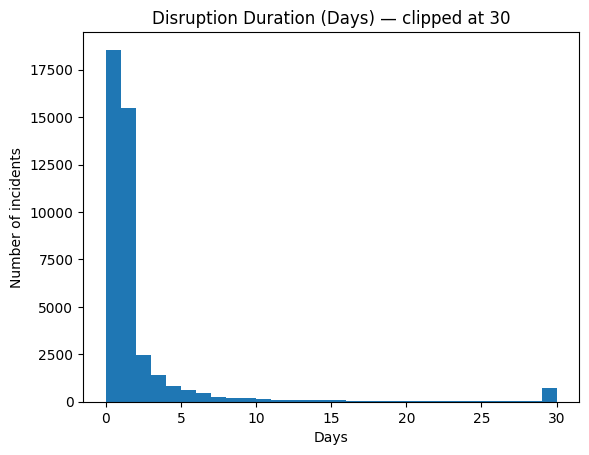

In [21]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(incidents_ok["disruption_days"].clip(upper=30), bins=30)
plt.title("Disruption Duration (Days) — clipped at 30")
plt.xlabel("Days")
plt.ylabel("Number of incidents")
plt.show()

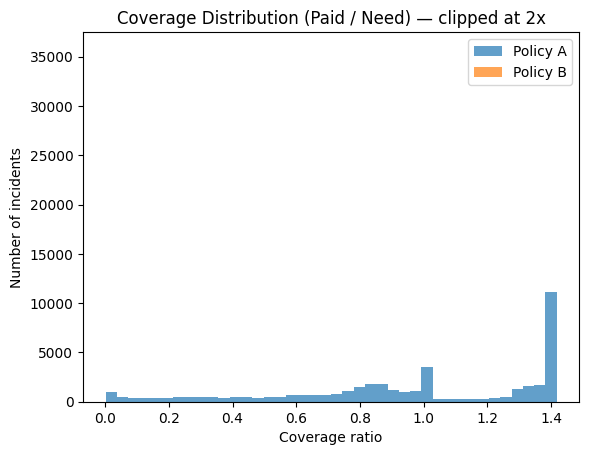

In [22]:
plt.figure()
plt.hist(incidents_ok["covA"].clip(upper=2), bins=40, alpha=0.7, label="Policy A")
plt.hist(incidents_ok["covB"].clip(upper=2), bins=40, alpha=0.7, label="Policy B")
plt.title("Coverage Distribution (Paid / Need) — clipped at 2x")
plt.xlabel("Coverage ratio")
plt.ylabel("Number of incidents")
plt.legend()
plt.show()

Title: Wildfire Recovery Micro-Grant Allocator (Route 2: Economic Resilience)

Method (pe scurt):

We construct an incident “disruption window” using WatchDuty change logs (start_time to end_time, number of updates).

We define a disruption proxy (disruption_days × severity_score) to estimate relative workdays at risk.

We convert the disruption proxy into an interpretable micro-grant need estimate (calibratable in a real pilot).

We compare two allocation policies under a fixed budget:

Flat grants per incident

Targeted grants proportional to estimated need

We summarize coverage and targeting performance.

What success looks like (Route 2 mapping):

Quantifiable workdays preserved (proxy)

Wages protected via improved targeting (higher coverage among high-need incidents)

A reproducible policy tool (budget → allocation → coverage)

In [25]:
def is_evacuation_order(change):
    # dacă nu e dict, sigur nu e order
    if not isinstance(change, dict):
        return False

    # verificăm mai multe câmpuri posibile
    possible_keys = ["status", "external_status"]

    for key in possible_keys:
        if key in change:
            val = change.get(key)

            # dacă e listă, luăm ultima valoare (noul status)
            if isinstance(val, list):
                val = val[-1]

            # normalizăm la string mic
            if isinstance(val, str):
                v = val.lower()

                # căutăm "order" în text (ex: "Evacuation Order", "ORDER", etc.)
                if "order" in v:
                    return True

    return False

In [ ]:
evac_changelog["is_evac_order"] = evac_changelog["changes_dict"].apply(is_evacuation_order)
evac_changelog["is_evac_order"].sum()

np.int64(208)

In [ ]:
print(evac_changelog.columns)

Index(['id', 'date_created', 'changes', 'evac_zone_id', 'changes_dict',
       'is_evac_order'],
      dtype='object')


In [ ]:
# Afișăm numele coloanelor ca să știm ce ID de zonă există în evac_changelog
print(evac_changelog.columns)

Index(['id', 'date_created', 'changes', 'evac_zone_id', 'changes_dict',
       'is_evac_order'],
      dtype='object')


In [ ]:
# Convertim timpul în datetime (dacă nu e deja)
evac_changelog["date_created"] = pd.to_datetime(evac_changelog["date_created"], errors="coerce")

# Păstrăm doar rândurile care sunt evacuation orders
orders = evac_changelog[evac_changelog["is_evac_order"]].copy()

# Pentru fiecare zonă (evac_zone_id), luăm primul moment când apare order (T2)
T2 = (
    orders.groupby("evac_zone_id")["date_created"]
    .min()
    .reset_index()
    .rename(columns={"date_created": "T2_evac_order"})
)

print("T2 shape:", T2.shape)
T2.head()


T2 shape: (186, 2)


,evac_zone_id,T2_evac_order
0,4602,2025-06-13 00:30:51.576399+00:00
1,4616,2025-06-13 00:47:27.312292+00:00
2,4851,2025-06-28 02:04:23.204358+00:00
3,5482,2025-06-04 00:37:53.270287+00:00
4,6288,2025-06-18 20:45:46.776645+00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
print(evac_changelog.columns)

Index(['id', 'date_created', 'changes', 'evac_zone_id', 'changes_dict',
       'is_evac_order'],
      dtype='object')


In [ ]:
print(T2.shape)
T2.head()

(186, 2)


,evac_zone_id,T2_evac_order
0,4602,2025-06-13 00:30:51.576399+00:00
1,4616,2025-06-13 00:47:27.312292+00:00
2,4851,2025-06-28 02:04:23.204358+00:00
3,5482,2025-06-04 00:37:53.270287+00:00
4,6288,2025-06-18 20:45:46.776645+00:00


In [ ]:
# Citim doar coloanele necesare (id, uid_v2) ca să evităm problemele din geom
evac_zones = pd.read_csv(
    "evac_zones_gis_evaczone.csv",
    sep=",",
    engine="python",
    quoting=3,
    usecols=["id", "uid_v2"]   # citim DOAR ce ne trebuie
)

# Construim tabelul de legătură evac_zone_id -> uid_v2
zone_link = evac_zones.rename(columns={"id": "evac_zone_id"}).copy()

print("zone_link loaded ✅", zone_link.shape)
zone_link.head()

zone_link loaded ✅ (5697, 2)


,,,,,evac_zone_id,uid_v2
1,2025-04-10 13:22:22.896704+00,2025-08-19 01:58:01.009206+00,boulder-CO_US-BO-030-cc87104888faec63,True,BO-030,boulder-CO_US
2,2025-04-10 13:22:22.896921+00,2025-08-19 01:58:01.00957+00,boulder-CO_US-BO-023-bf0c7318a31e33c2,True,BO-023,boulder-CO_US
3,2025-04-10 13:22:22.897002+00,2025-08-19 01:58:01.009741+00,boulder-CO_US-BO-031-d365d7b1d6a30d16,True,BO-031,boulder-CO_US
4,2025-04-10 13:22:22.897075+00,2025-08-19 01:58:01.009867+00,boulder-CO_US-BO-005-ccd5de89e7c9e57a,True,BO-005,boulder-CO_US
5,2025-04-10 13:22:22.897156+00,2025-08-19 01:58:01.010002+00,boulder-CO_US-BO-028-2693ee3d2f362647,True,BO-028,boulder-CO_US
